# Group Project: Composite Urban Heat Risk Index via PCA

### Kefeng Shi, Zhi Wang

## Overview:
Our research start with importing the datasets, after that, we will count the total number of cooling features across NTAs, we will plot out the locations of the cooling features. Then, we will transfer the AC percentage data documented in PUMA regime into NTA regime, we will make a barplot to visualize three indexes for different boroughs. Finally we will use the PCA approach to calculated NHVI (by the combination of AC%, cooling feature count, and original HVI) by NTA regime and make a map base on that; besides, we will create a biplot and loading map for each PC1 and PC2.

## Data Resources and Usage

The data used in this project comes from two main resources: 

Source (1): The Environment Health Data Portal from nyc.gov (https://a816-dohbesp.nyc.gov/IndicatorPublic/)

Source (2): The NYC Opendata Portal (https://opendata.cityofnewyork.us/)

The dataset we used can be categorized into four main aspects: the heat vulnerability index (HVI) from source (1), the household air conditioner percentage from source (1), the cooling feature data from source (2) that contains the census data from the "Cool It! NYC 2020" project on spray showers, cooling fountains, and other cooling sites; our research also requires the GIS data that help us plot the distribution by NYC's NTA2020 (Neighborhood Tabulation Area) & PUMA2010 from source (2)

## (1) Import packages

We load pandas and geopandas for data manipulation and spatial analysis, matplotlib for plotting, and sklearn for implementing the PCA model. Additionally, a patch for the shapely library is included to prevent common geometry-related errors.

In [17]:
import shapely.geometry.base
if hasattr(shapely.geometry.base.BaseMultipartGeometry, "__array_interface__"):
    del shapely.geometry.base.BaseMultipartGeometry.__array_interface__
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## (2) Prepare the NTA layer, PUMA layer, and overlap layers form AC data

Here, we outline the primary data sources used for our analysis, namely the NYC Environment Health Data Portal and the NYC Open Data Portal. This section details the four key types of data we utilized: the Heat Vulnerability Index (HVI), household air conditioner ownership rates, geographic locations of public cooling features (like spray showers and fountains), and the GIS files needed for mapping.
In this cell, we load the core geographic data: NTA and PUMA shapefiles. We standardize their coordinate reference systems (CRS) for compatibility and then perform a spatial join to match each NTA with its corresponding PUMA. This step is crucial for later integrating the PUMA-level air conditioner data into our NTA-level dataset.

In [30]:
#load PUMA layer for AC data
gdf_puma = (
    gpd.read_file("tl_2017_36_puma10.shp")
       .to_crs("EPSG:4326")
)

# In order to create a 4-digit PUMA column, we strip off the leading zero of PUMACE10
gdf_puma["PUMA"] = gdf_puma["PUMACE10"]\
                      .astype(str)\
                      .str[-4:]\
                      .str.zfill(4)
#Load NTA data
gdf_nta = gpd.read_file("nynta2020.shp").to_crs("EPSG:4326")
gdf_boro = gdf_nta.dissolve(by="BoroName")[["geometry"]].reset_index()
# compute centroids in projected CRS for accuracy
nta_cent = (
    gdf_nta
    .to_crs("EPSG:3857")
    .assign(geometry=lambda df: df.geometry.centroid)
    .to_crs("EPSG:4326")[["NTAName","geometry"]]
)

nta_puma = (
    gpd.sjoin(nta_cent,
              gdf_puma[["PUMA","geometry"]],
              how="left",
              predicate="within")
      .drop_duplicates("NTAName")[["NTAName","PUMA"]]
)

# (3) Load and count the cooling features per NTA

The cooling feature consists of spray showers, cooling fountains, and other cooling sites, each of these cooling features has its latitude and longitude, we use the GeoDataFrame to determine their location within each NTA area and then calculate the sum of the count.

This is the core analytical cell of the project, bringing together all data sources. We first load and spatially join cooling feature data to count sites per NTA, then load and merge the HVI and AC percentage data. Finally, we run a Principal Component Analysis (PCA) to compute our composite heat risk index (BABI) and generate a choropleth map to visualize the results across NYC neighborhoods.

In [31]:
# Load & count cooling points per NTA
df_cool = pd.read_csv("nyc_cool.csv")
df_cool = df_cool[df_cool.Status=="Activated"].dropna(subset=["x","y"]).copy()
gdf_cool = gpd.GeoDataFrame(df_cool,
    geometry=gpd.points_from_xy(df_cool.x, df_cool.y),
    crs="EPSG:4326"
)

borough_map = {"B":"Brooklyn","X":"Bronx","M":"Manhattan","m":"Manhattan","Q":"Queens","R":"Richmond"}
layers = {
    "Spray Showers":      "Cool_It__NYC_2020_-_Spray_Showers_20250618.csv",
    "Drinking Fountains": "Cool_It__NYC_2020_-_Drinking_Fountains_20250618.csv"
}
gdfs = {}
for label, fp in layers.items():
    df = pd.read_csv(fp)
    key = "Status" if "Status" in df.columns else "DF Activated"
    df = df[df[key]=="Activated"].dropna(subset=["x","y","Borough"]).copy()
    df["Borough"] = df["Borough"].map(borough_map)
    gdfs[label] = (
        gpd.GeoDataFrame(df,
            geometry=gpd.points_from_xy(df.x, df.y),
            crs="EPSG:2263"
        )
        .to_crs("EPSG:4326")
    )

all_pts = pd.concat([gdfs["Drinking Fountains"], gdfs["Spray Showers"], gdf_cool], ignore_index=True)
all_pts = gpd.GeoDataFrame(all_pts, geometry=all_pts.geometry, crs="EPSG:4326")
pt_join = gpd.sjoin(all_pts, gdf_nta[["NTAName","geometry"]], how="left", predicate="within")
site_counts = pt_join.groupby("NTAName").size().reset_index(name="site_count")

## (4) Load HVI and AC Percentage data

### The bottom two pictures come from the nyc.gov's environment health department which shows the distribution of HVI by NTA in the year of 2023 (top), and the distribution of AC percentage in 2017 (bottom). 

For the AC data we take the 2017 data instead of 2023, because the 2023 data has too much N/A.

https://a816-dohbesp.nyc.gov/IndicatorPublic/data-explorer/climate/?id=2185#display=map

https://a816-dohbesp.nyc.gov/IndicatorPublic/data-explorer/climate/?id=2411#display=map


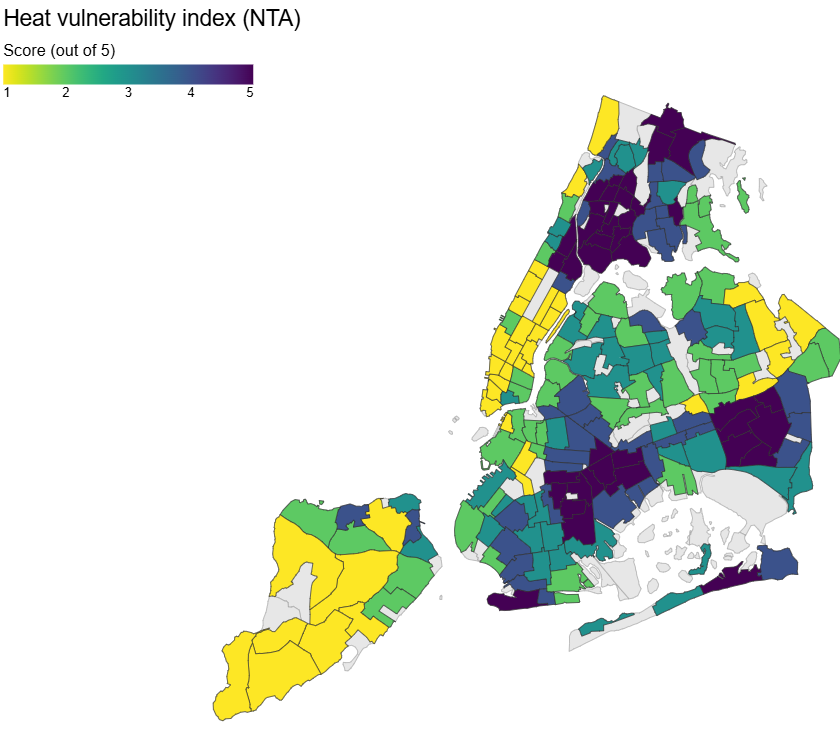

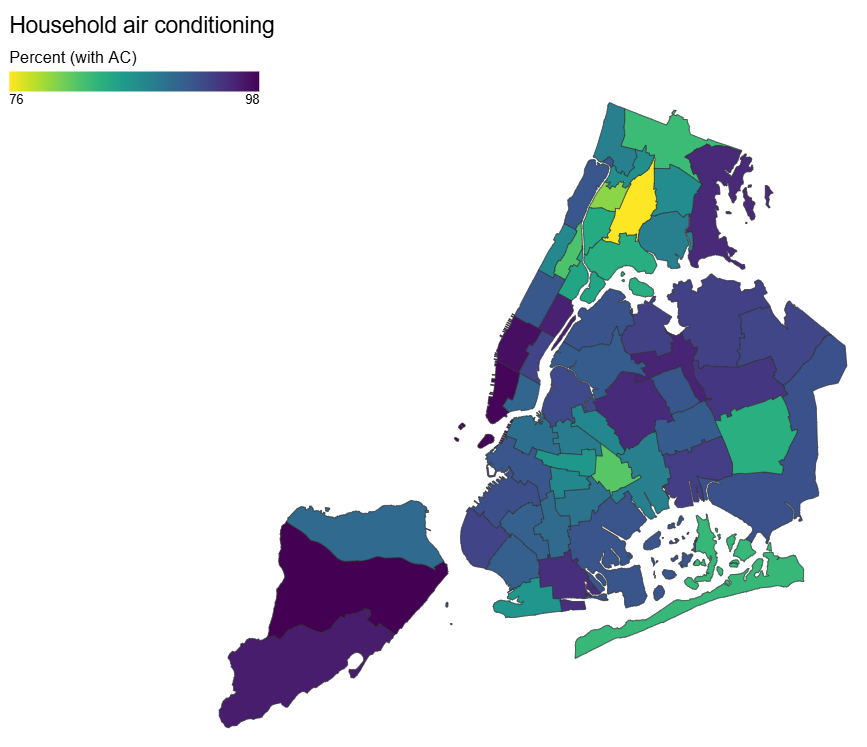

In [32]:
# Load HVI data
hvi_df = pd.read_csv("NYC EH Data Portal - Heat vulnerability index (NTA) (full table) (2).csv")
hvi = (hvi_df
       .rename(columns={"Geography":"NTAName","Score out of 5":"HVI"})
       [["NTAName","HVI"]]
)

# Load 2017 AC% data by PUMA
ac_df = pd.read_csv("NYC EH Data Portal - Household air conditioning (full table).csv")
if "TimePeriod" in ac_df.columns:
    ac_df = ac_df[ac_df["TimePeriod"] == 2017].copy()
ac = (ac_df
      .rename(columns={"GeoID":"PUMA","Percent (with AC)":"AC_pct"})
      [["PUMA","AC_pct"]]
)

ac["AC_pct"] = ac["AC_pct"].str.extract(r"([\d\.]+)").astype(float)
ac["PUMA"] = ac["PUMA"].astype(str).str.zfill(4)


## (5) Bring all data together

In [33]:
# Merge into NHVI table
nhvi = (
    pd.DataFrame({"NTAName":gdf_nta.NTAName})
      .merge(site_counts, on="NTAName", how="left")
      .merge(hvi,         on="NTAName", how="left")
      .merge(nta_puma,    on="NTAName", how="left")
      .merge(ac,          on="PUMA",    how="left")
)
nhvi[["site_count","HVI","AC_pct"]] = nhvi[["site_count","HVI","AC_pct"]].fillna(0)

## (5).1 Merge into borough scales and calculate the borough mean

In [34]:
nhvi = nhvi.merge(
    gdf_nta[["NTAName","BoroName"]],
    on="NTAName",
    how="left"
)
borough_means = (
    nhvi.loc[nhvi["AC_pct"] > 0]
        .groupby("BoroName")["AC_pct"]
        .mean()
        .to_dict()
)
global_mean = nhvi.loc[nhvi["AC_pct"] > 0, "AC_pct"].mean()
def impute_ac(row):
    return row["AC_pct"] if row["AC_pct"] > 0 else borough_means.get(row["BoroName"], global_mean)
nhvi["AC_pct_imputed"] = nhvi.apply(impute_ac, axis=1)

## (6) Exploratory data input distribution

In [35]:
print("site_count (all values):")
print(nhvi["site_count"].describe(), "\n")
print("HVI (excluding zero values):")
print(nhvi.loc[nhvi["HVI"] > 0, "HVI"].describe(), "\n")
print("AC_pct (excluding zero values):")
print(nhvi.loc[nhvi["AC_pct"] > 0, "AC_pct"].describe(), "\n")

site_count (all values):
count    262.000000
mean      16.980916
std       20.094309
min        0.000000
25%        6.000000
50%       12.500000
75%       21.000000
max      189.000000
Name: site_count, dtype: float64 

HVI (excluding zero values):
count    197.000000
mean       3.030457
std        1.406648
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: HVI, dtype: float64 

AC_pct (excluding zero values):
count    262.000000
mean      90.812595
std        5.026995
min       75.800000
25%       88.100000
50%       92.200000
75%       94.100000
max       98.400000
Name: AC_pct, dtype: float64 



## Histogram of the input factors

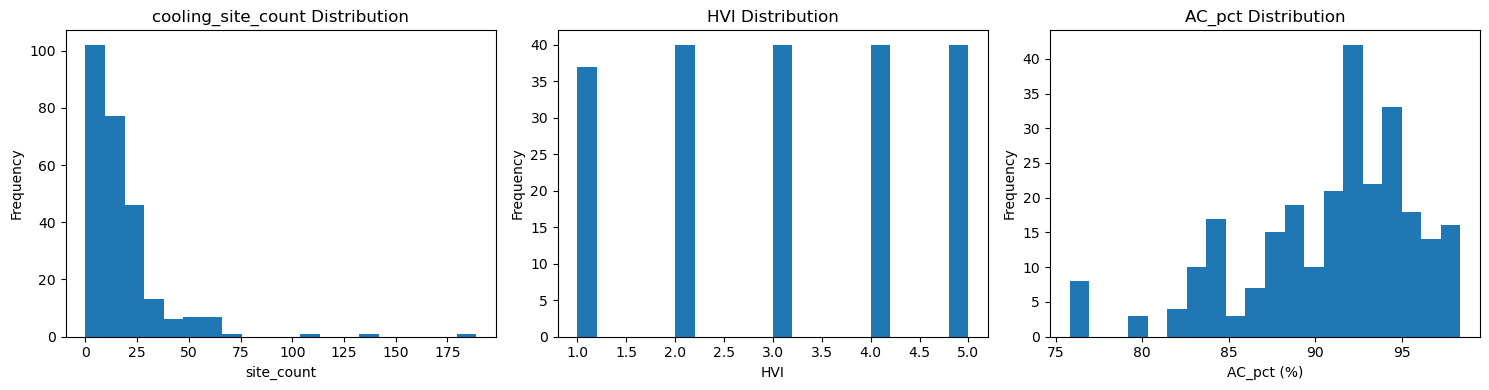

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
nhvi["site_count"].plot.hist(
    bins=20, ax=axes[0], title="cooling_site_count Distribution"
)
axes[0].set_xlabel("site_count")

nhvi.loc[nhvi["HVI"] > 0, "HVI"].plot.hist(
    bins=20, ax=axes[1], title="HVI Distribution"
)
axes[1].set_xlabel("HVI")

nhvi.loc[nhvi["AC_pct"] > 0, "AC_pct"].plot.hist(
    bins=20, ax=axes[2], title="AC_pct Distribution"
)
axes[2].set_xlabel("AC_pct (%)")
plt.tight_layout()
plt.show()

The distribution of the cooling site count skews to left. The AC percentage data skewed to right.

## The mean value of the imput factors by borough

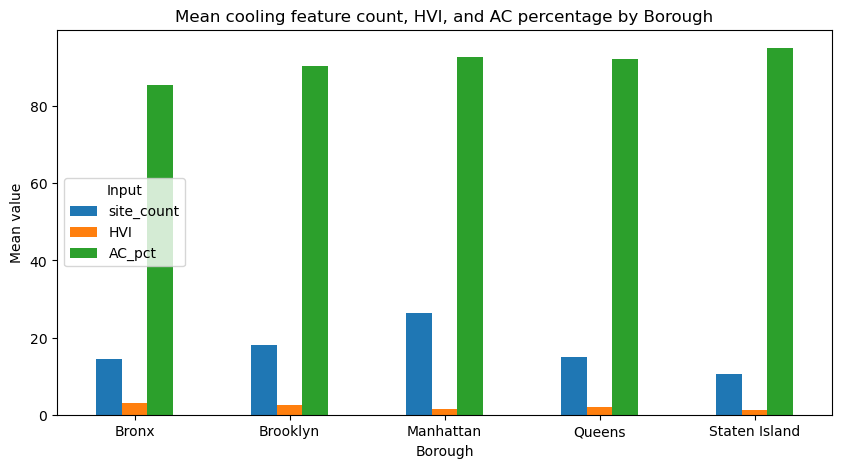

In [37]:
borough_means = nhvi.groupby("BoroName")[["site_count","HVI","AC_pct"]].mean()

ax = borough_means.plot(
    kind="bar", figsize=(10,5),
    title="Mean cooling feature count, HVI, and AC percentage by Borough",
    rot=0
)
ax.set_ylabel("Mean value")
ax.set_xlabel("Borough")
ax.legend(title="Input", loc="center left")
plt.show()


Staten Island has the highest household air conditioner percentage, yet it also have the lowest cooling site count. Bronx has the lowest AC% and highest HVI, so it is the most vulnerable to extreme heat events.

## The mapping of the cooling feature counts per NTA. Green can represent a "community cooling center"

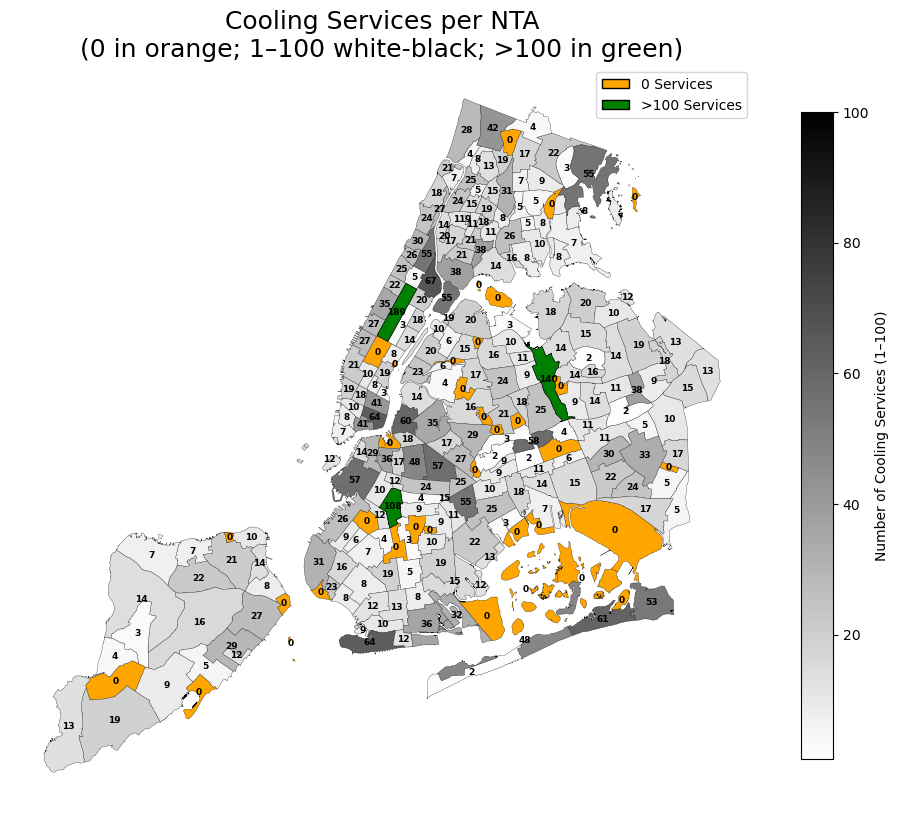

In [38]:
if "site_count" not in gdf_nta.columns:
    gdf_nta = gdf_nta.merge(site_counts, on="NTAName", how="left")
    gdf_nta["site_count"] = gdf_nta["site_count"].fillna(0).astype(int)
# Three types of count, where we will attribute them with different color (0 services = orange, >100 services = green, 0-100 = white-black)
gdf_zero = gdf_nta[gdf_nta["site_count"] == 0]
gdf_low  = gdf_nta[(gdf_nta["site_count"] > 0) & (gdf_nta["site_count"] <= 100)]
gdf_high = gdf_nta[gdf_nta["site_count"] > 100]


fig, ax = plt.subplots(1, 1, figsize=(12,12))
gdf_zero.plot(color="orange", edgecolor="black", linewidth=0.2, ax=ax, label="no Services")

low_plot = gdf_low.plot(
    column="site_count",
    cmap="binary",
    vmin=1, vmax=100,
    legend=True,
    legend_kwds={
        "label":"Number of Cooling Services (1–100)",
        "shrink":0.7,
    },
    edgecolor="black",
    linewidth=0.2,
    ax=ax
)

gdf_high.plot(color="green", edgecolor="black", linewidth=0.5, ax=ax, label=">100 Services")


for _, row in gdf_nta.iterrows():
    x, y = row.geometry.centroid.coords[0]

    ax.text(x, y, str(row.site_count),
            ha="center", va="center",
            fontsize=6.5, fontweight="bold")

ax.legend(
    handles=[
        Patch(facecolor="orange", edgecolor="black", label="0 Services"),
        Patch(facecolor="green",     edgecolor="black", label=">100 Services")
    ],
)
ax.set_title("Cooling Services per NTA\n(0 in orange; 1–100 white-black; >100 in green)", fontsize=18)
ax.set_axis_off()
plt.show()


## (7) PCA calculation and then merge it back to our NTA map

NHVI is the final combination of the three factors using the PCA, and it is the PC1 of the PCA, which can explain the largest share of varianca across the factors and communities.

In [39]:
# Covariance matrix
Xmat = pd.DataFrame({
    "site_count_neg": -nhvi["site_count"],  # more sites → more negative → lower BABI
    "HVI":            nhvi["HVI"],          # higher HVI → higher BABI
    "AC_pct_neg":     -nhvi["AC_pct"]        # more AC → more negative → lower BABI
})

# Standardize
X = StandardScaler().fit_transform(Xmat)
pca = PCA(n_components=1)
nhvi["NHVI"] = pca.fit_transform(X).flatten()

# Normalized
load = pca.components_[0]
weights = abs(load) / abs(load).sum()
print("PCA‐derived weights (for site_count_neg, HVI, AC_pct_neg):",
      dict(zip(Xmat.columns, weights.round(3))))
gdf_nta = gdf_nta.merge(nhvi[["NTAName","NHVI"]], on="NTAName")

PCA‐derived weights (for site_count_neg, HVI, AC_pct_neg): {'site_count_neg': np.float64(0.134), 'HVI': np.float64(0.43), 'AC_pct_neg': np.float64(0.436)}


## (8) Plot the choropleth of our NHVI by NTA.

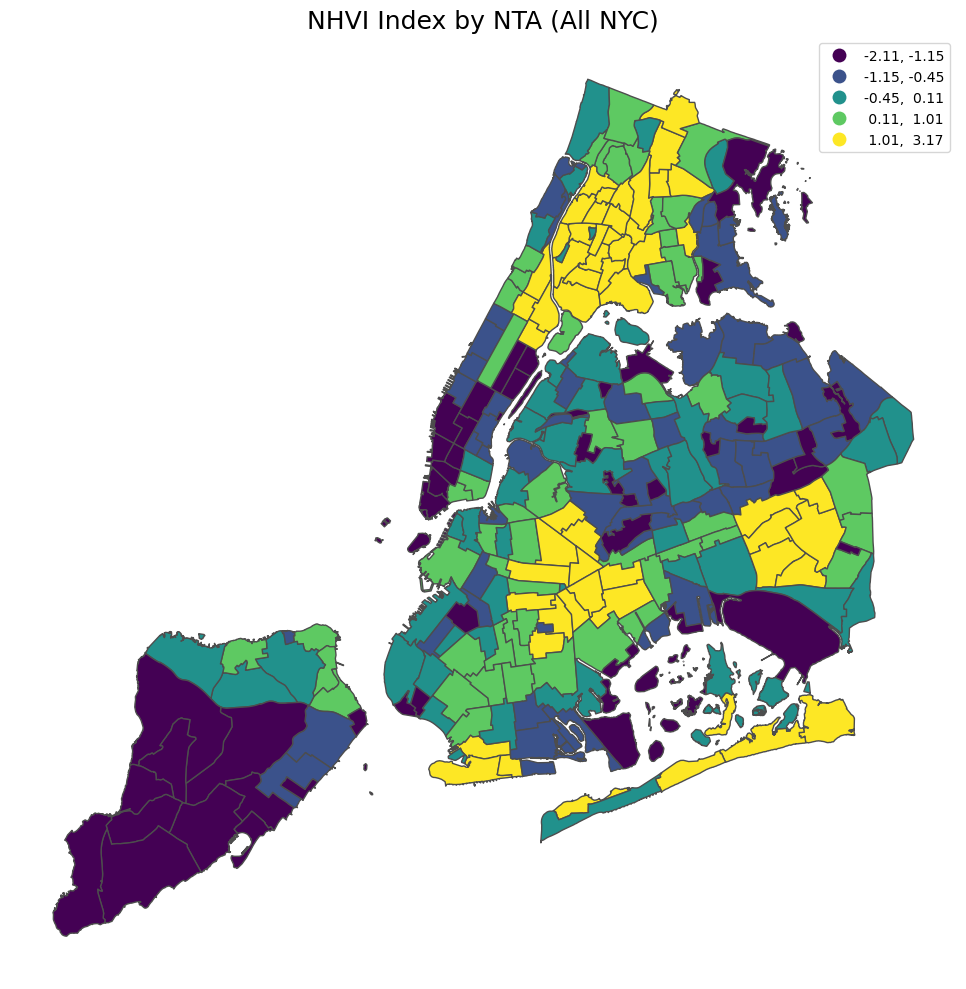

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_nta.plot(column="NHVI", cmap="viridis", scheme="quantiles",
             legend=True, ax=ax, edgecolor="0.3")
ax.set_title("NHVI Index by NTA (All NYC)", fontsize=18)
ax.set_axis_off()
plt.tight_layout()
plt.savefig("babi_nyc_choropleth.png", dpi=300)
plt.show()

For the NHVI, higher NHVI means more deficit in cooling resources (including air conditioners and cooling features). As we will see later in the scatterplot, actually air conditioner make a lot of contributions in calculating the NHVI (or PC1), so places with low or no AC % will for sure have lower NHVI, like what we see in places like Bronx and Jamaica area. While the case for the Staten Island is that even though the borough is not rich in cooling feature counts, it has high household AC %, so the NHVI there is low, meaning that the place is less vulnerable in extreme heat.

## (9) Plot the PC1 vs PC2 biplot to see how each factor contributes to the two axes, and also their loadings correspondedly. (Each blue points stands for one NTA).

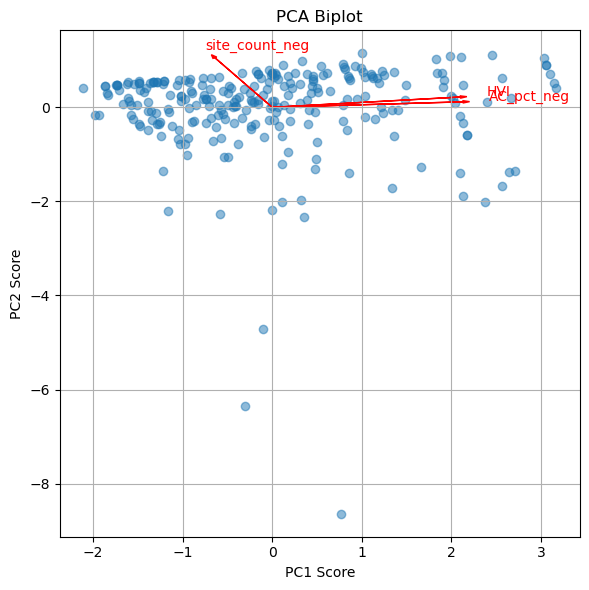

In [41]:
# Fit PCA
pca = PCA(n_components=2)
scores = pca.fit_transform(X)      
loadings = pca.components_              

plt.figure(figsize=(6,6))
plt.scatter(scores[:,0], scores[:,1], alpha=0.5)
for i, var in enumerate(Xmat.columns):
    plt.arrow(
        0, 0,
        loadings[0, i] * max(scores[:,0]),
        loadings[1, i] * max(scores[:,1]),
        head_width=0.05, length_includes_head=True, color="red"
    )
    plt.text(
        loadings[0, i] * max(scores[:,0]) * 1.1,
        loadings[1, i] * max(scores[:,1]) * 1.1,
        var,
        color="red"
    )
plt.title("PCA Biplot")
plt.xlabel("PC1 Score")
plt.ylabel("PC2 Score")
plt.grid(True)
plt.tight_layout()
plt.show()


This cell is dedicated to visualizing and interpreting the results of our PCA model. It generates a Biplot to visually demonstrate the relationship between the original variables and the principal components. We will focus on PC1, because it captures the majority of the variation in our three metrics and directly encodes the main trade-off between cooling infrastructure and heat vulnerability.

The first principal component (PC1) separates neighborhoods along a “cooling-infrastructure abundance ↔ heat-vulnerability” axis: NTAs with negative PC1 scores tend to have many cooling sites, high air-conditioning coverage and low heat-vulnerability, whereas those with positive PC1 scores have few cooling sites, low AC penetration and high vulnerability. On the other hand, the HVI arrow and the “neg_AC” arrow lie almost on top of one another, this tells us that they load very similarly on PC1 and they’re nearly perfectly correlated.